# Module 2 Assignment

<a target="_blank" href="https://colab.research.google.com/github/simonguest/CS-394/blob/main/src/02/notebooks/gradio.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://github.com/simonguest/CS-394/raw/refs/heads/main/src/02/notebooks/gradio.ipynb">
  <img src="https://img.shields.io/badge/Download_.ipynb-blue" alt="Download .ipynb"/>
</a>

## Install gradio

In [1]:
!pip install gradio==5.49.1 openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.9 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.41.4
    Uninstalling pydantic_core-2.41.4:
      Successfully uninstalled pydantic_core-2.41.4
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.12.3
    Uninstalling pydantic-2.12.3:
      Successfully uninstalled pydantic-2.12.3
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.14.0
    Uninstalling gradio_client-1.14.0:
      Successfully uninstalled gradio_client-1.14.0
  Attempting uninstall: gradio
    Found existing installation: gradio 5.

## Set the OpenRouter API Key from Colab Secrets

In [2]:
from google.colab import userdata
OPENROUTER_API_KEY = userdata.get('OpenRouter')

## Program Sample

In [14]:
import os
import json
import gradio as gr
from pydantic import BaseModel, ValidationError
from openai import OpenAI
from typing import List

MODELS = {
    "openai/gpt-5.2-chat": "openai/gpt-5.2-chat",
    "MiMo-V2-Flash (free)": "xiaomi/mimo-v2-flash:free",
}

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
    default_headers={
        "HTTP-Referer": "http://localhost:7860",
        "X-Title": "Game Recommendation Assistant",
    },
)

class GameInformation(BaseModel):
    name: str
    genre: str
    console: str
    price: str
    year: int

DELIM = "---JSON---"

SYSTEM = f"""
You help users find the game they are looking for.

Output format rules:
1) First: reply normally in plain English (recommendations + brief reasoning).
   - Include a short section titled "GameInformation (summary)".
   - In that section, list each recommended game in 1 line using this format:
     Name | Genre | Console | Price | Year
   - Do NOT use JSON in this first section.

2) Then on a new line output exactly: {DELIM}

3) Then output ONLY valid JSON as an ARRAY of objects (a list), each object with keys:
   name, genre, console, price, year

No markdown code fences. No extra text after the JSON.
"""

STARTER = "What kind of game are you looking for?"

def history_to_messages(history):
    messages = [{"role": "system", "content": SYSTEM}]
    for u, a in history:
        if u:
            messages.append({"role": "user", "content": u})
        if a:
            messages.append({"role": "assistant", "content": a})
    return messages

def chat(model_label, user_msg, history):
    model_id = MODELS[model_label]

    messages = history_to_messages(history)
    messages.append({"role": "user", "content": user_msg})

    # add new row and clear textbox right away
    history = history + [[user_msg, ""]]
    yield history, "", None

    stream = client.chat.completions.create(
        model=model_id,
        messages=messages,
        temperature=0.7,
        stream=True,
    )

    visible_text = ""
    json_text = ""
    saw_delim = False

    for chunk in stream:
        delta = chunk.choices[0].delta
        token = getattr(delta, "content", None)
        if not token:
            continue

        if not saw_delim:
            visible_text += token

            if DELIM in visible_text:
                before, after = visible_text.split(DELIM, 1)
                visible_text = before.rstrip()
                json_text += after
                saw_delim = True

            history[-1][1] = visible_text
            yield history, "", None
        else:
            json_text += token

    # Parse JSON after streaming completes
    json_blob = json_text.strip()

    try:
        data = json.loads(json_blob)
        if not isinstance(data, list):
            raise ValidationError.from_exception_data(
                "GameInformationList",
                [{"loc": ("root",), "msg": "Expected a JSON array (list) of games.", "type": "value_error"}],
            )

        games: List[GameInformation] = [GameInformation(**item) for item in data]
        json_out = [g.model_dump() for g in games]

    except Exception as e:
        json_out = {
            "error": "Could not parse valid JSON array of GameInformation after delimiter.",
            "details": str(e),
            "raw_json_section": json_blob,
            "raw_visible_section": visible_text.strip(),
        }

    yield history, "", json_out

with gr.Blocks() as demo:
    gr.Markdown("## Game Recommendation Assistant")

    model_dd = gr.Dropdown(list(MODELS.keys()), value=list(MODELS.keys())[0], label="Model")
    chatbot = gr.Chatbot(label="Chat", height=360, value=[[None, STARTER]])
    txt = gr.Textbox(label="Your message")
    send = gr.Button("Send")
    json_panel = gr.JSON(label="GameInformation list (parsed after completion)")

    send.click(chat, inputs=[model_dd, txt, chatbot], outputs=[chatbot, txt, json_panel])
    txt.submit(chat, inputs=[model_dd, txt, chatbot], outputs=[chatbot, txt, json_panel])

demo.launch()


/tmp/ipython-input-738706909.py:129: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Chat", height=360, value=[[None, STARTER]])
/tmp/ipython-input-738706909.py:129: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot(label="Chat", height=360, value=[[None, STARTER]])


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2b5842b56ba8b491e5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# What Does this Notebook Do?
## Overview
This program, Game Recommendation Assistant, is designed to help users find games they are looking for and output the results in a structured JSON format called GameInformation, which includes the following fields: name, genre, console, price, and year.

To make the system feel more like an assistant rather than a simple database lookup, the program is designed to first generate a natural, conversational response. After that, it provides game recommendations along with detailed information formatted as JSON, allowing users to review and use the data to support their decision-making.

## Technical Overview
The program separates its output into two parts: a visible text response and a JSON output. The visible text is intended for human interaction, while the JSON output is structured for programmatic use.

At the moment, parsing the JSON may not have an immediate practical application, but this implementation is intentional. I wanted to learn how to extract and validate structured data generated by a language model for future use cases. For example, in game development, JSON generated by an LLM could be directly consumed by a game system, recommendation engine, or data pipeline. Additionally, users can reuse the generated JSON output for their own data processing or integration needs.


# Performance differences between openai/gpt-5.2-chat and MiMo-V2-Flash (free)
## Let's see the performance differences between 2 models when I asked "give me games with a character named Simon"?




# openai/gpt-5.2-chat

## Chat Output
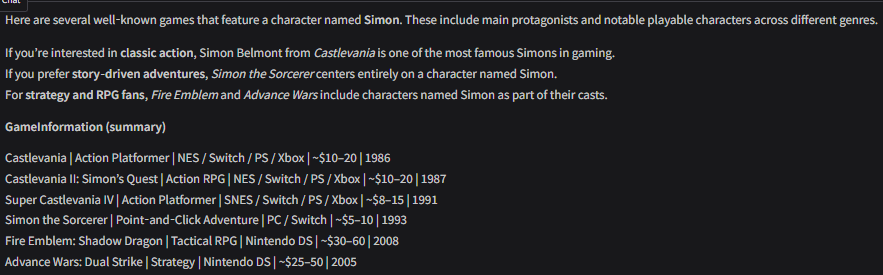

## JSON Output
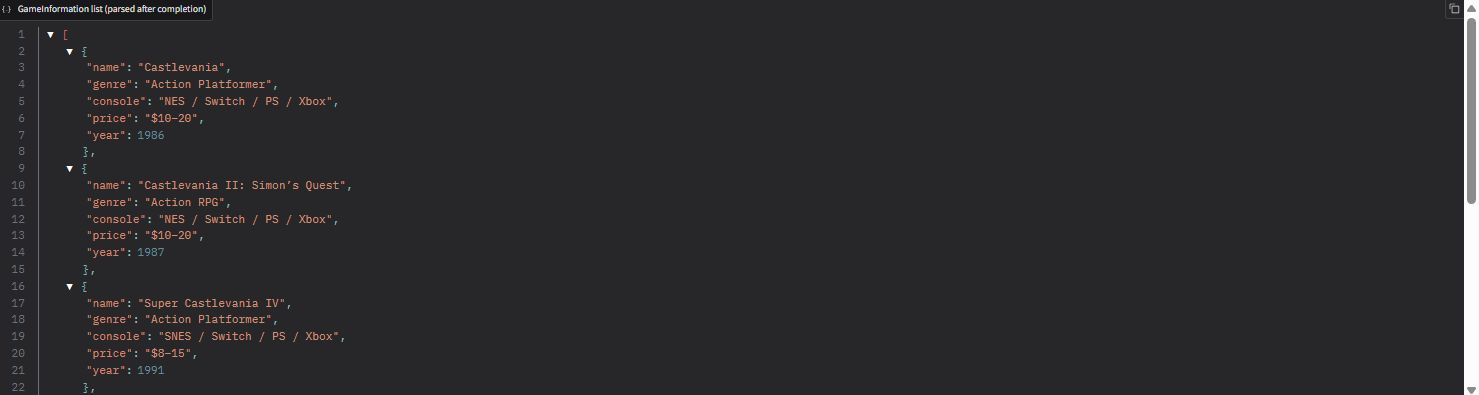

# MiMo-V2-Flash (free)
## Chat Output
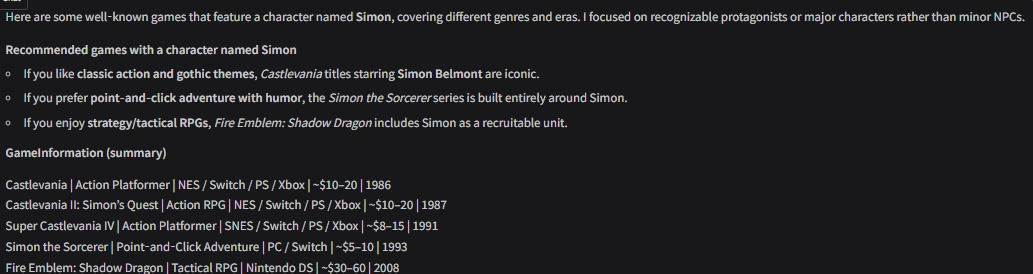

## JSON Output

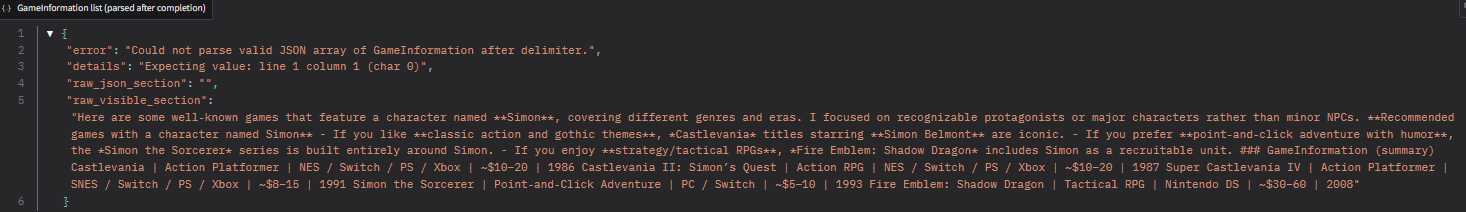

## Comparison
Based on these examples, in my opinion, when using a temperature of 0.7, the chat outputs from the paid and free models are generally very similar. In terms of conversational quality, there is no significant difference between the two.

However, one important difference is that the paid model is able to reliably generate valid JSON, while the free model struggles to do so. This capability is crucial in practical applications. For example, if I want to update a game state in Unity by parsing JSON generated by the model, I need the output to follow a strict and consistent structure. In this case, using the paid model becomes necessary to ensure reliable integration.